In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize

ModuleNotFoundError: No module named 'pandas'

In [25]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()


,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [5]:
import numpy as np
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split


# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=3)
df_imputed = knn_imputer.fit_transform(df)


# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)


# Features & Target
x = df_imputed[[
    'Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min', 'Fraction inspired oxygen_max', \
    'Glucose_mean', 'Glucose_min', 'Glucose_max', \
    'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',\
    'Mean blood pressure_mean', 'Mean blood pressure_min', 'Mean blood pressure_max', \
    'Diastolic blood pressure_mean', 'Diastolic blood pressure_min', 'Diastolic blood pressure_max',\
    'Systolic blood pressure_mean', 'Systolic blood pressure_min', 'Systolic blood pressure_max',\
    'Oxygen saturation_mean', 'Oxygen saturation_min', 'Oxygen saturation_max',\
    'Respiratory rate_mean', 'Respiratory rate_min', 'Respiratory rate_max',\
    'Temperature_mean', 'Temperature_min', 'Temperature_max',\
    'Weight_mean', 'Weight_min', 'Weight_max',\
    'pH_mean', 'pH_min', 'pH_max']]
y = df_imputed['mortality']


# Applying SMOTE
smote = SMOTE(random_state = 42)
x_resampled, y_resampled = smote.fit_resample(x, y)


print('Original Dataset Shape:', y.value_counts())
print('\nResampled Dataset Shape:', y_resampled.value_counts())


print ('\n-------------------------------------------------------------------')
# Function to Detect Outliers using IQR
def detect_outlier_iqr(data):
  outliers = {}
  for column in df.columns:
      Q1 = data[column].quantile(0.25)
      Q3 = data[column].quantile(0.75)
      IRQ = Q3 - Q1
      lower_bound = Q1 - 1.5*IRQ
      upper_bound = Q3 + 1.5*IRQ
      outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
  return outliers

# Combine feataures and target variable for outlier detection
resampled_data = pd.DataFrame(x_resampled, columns=x.columns)
resampled_data['mortality'] = y_resampled

# Checking for Outliers in the Resampled Data
outliers_in_resampled = detect_outlier_iqr(pd.DataFrame(resampled_data))
for feature, outliers in outliers_in_resampled.items():
    print(f"Outliers detected in'{feature}':")
    print(outliers)
    print('\n~~~~~~~~~~~~~~~~~~~~~')



Original Dataset Shape: 0.0    4232
1.0    1415
Name: mortality, dtype: int64

Resampled Dataset Shape: 1.0    4232
0.0    4232
Name: mortality, dtype: int64

-------------------------------------------------------------------
Outliers detected in'Fraction inspired oxygen_mean':
      Fraction inspired oxygen_mean  Fraction inspired oxygen_min  \
60                         1.000000                      1.000000   
65                         1.000000                      1.000000   
98                         1.000000                      1.000000   
118                        0.862500                      0.700000   
158                        0.833333                      0.500000   
...                             ...                           ...   
8279                       0.875009                      0.500075   
8308                       0.830007                      0.807035   
8338                       0.815078                      0.500000   
8429                       0.9

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [39]:
y_test

2240    1.0
443     0.0
2752    0.0
5541    0.0
2760    0.0
       ... 
64      0.0
3656    0.0
888     0.0
3312    0.0
5464    0.0
Name: mortality, Length: 1695, dtype: float64

In [60]:
import lightgbm as lgb
print(lgb.__version__)

import lightgbm as lgb

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

lgb_train = lgb.Dataset(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] Using self-defined objective function
(3952,)
(1695,)


ValueError: operands could not be broadcast together with shapes (3952,) (1695,) 

In [ ]:
# build the lightgbm model
import lightgbm as lgb

from scipy import special

# Initialize the model
#clf = lgb.LGBMClassifier(objective=custom_objective, metric=custom_eval_metric)

# testing ONLY
def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _negative_sigmoid(x):
    exp = np.exp(x)
    return exp / (exp + 1)

def sigmoid(x):
    positive = x >= 0
    negative = ~positive
    result = np.empty_like(x)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])
    return result

def custom_loss(y_pred, dataset):

  t = dataset.get_label()
  y = sigmoid(y_pred)
  grad = y - t
  hess = y * (1 - y)

  return grad, hess

#https://maxhalford.github.io/blog/lightgbm-focal-loss/
def logloss_metric(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)

    ll = np.empty_like(p)
    pos = y == 1
    ll[pos] = np.log(p[pos])
    ll[~pos] = np.log(1 - p[~pos])

    is_higher_better = False
    return 'logloss', -ll.mean(), is_higher_better

def l2_eval(y, dataset):
    t = dataset.get_label()
    w = dataset.get_weight()
    loss = np.sum(w * (y - t)**2) / np.sum(w)
    return 'weighted_l2', loss, False

"""
# Custom evaluation metric
def custom_eval_metric(y_true, y_pred):
    # Convert predictions to probabilities
    y_pred = 1 / (1 + np.exp(-y_pred))
    return 'custom_logloss', log_loss(y_true, y_pred), False


clf = lgb.LGBMClassifier(objective=custom_loss2)
clf.fit(X_train, y_train)
y_val=clf.predict_proba(X_test)

"""
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

# Using built-in objective
lgbm_params = {
    #'metric':['auc','binary_logloss'],
    'metric':'None',
    'objective': custom_loss,
    'random_seed': 0,
    'num_leaves':30,
    'max_depth':50,
    'learning_rate':0.05,
    'reg_alpha' :5,
    'reg_lambda':5,
    'force_col_wise': 'true'
}


model = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    num_boost_round=100,
    #feval=l2_eval,
    feval = logloss_metric
)


y_pred=sigmoid(model.predict(X_train))
print('LightGBM Model training accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred>0.5)))

y_val=sigmoid(model.predict(X_test))
print('LightGBM Model training score: {0:0.4f}'.format(accuracy_score(lgb_train.get_label(), y_pred>0.5)))
# Note: When using custom objective, the model outputs logits


# view accuracy
#from sklearn.metrics import accuracy_score
#accuracy=accuracy_score(y_pred, y_test)

print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_val>0.5)))


# print the scores on training and test set

#print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
#print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces



Confusion matrix

 [[1173   82]
 [ 325  115]]

True Positives(TP) =  1173

True Negatives(TN) =  115

False Positives(FP) =  82

False Negatives(FN) =  325
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85      1255
         1.0       0.58      0.26      0.36       440

    accuracy                           0.76      1695
   macro avg       0.68      0.60      0.61      1695
weighted avg       0.73      0.76      0.72      1695



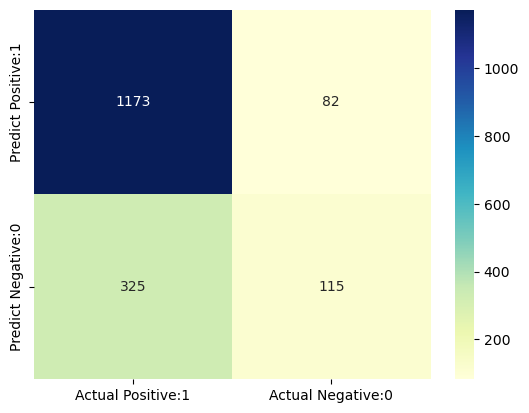

In [8]:

from sklearn.metrics import confusion_matrix
print(y_test)
print(y_val)
cm = confusion_matrix(y_test, y_val>0.5)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])



# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')



from sklearn.metrics import classification_report
print(classification_report(y_test, y_val>0.5))


In [ ]:
#https://towardsdatascience.com/understanding-the-roc-curve-in-three-visual-steps-795b1399481c
#https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.RocCurveDisplay.html


import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


#disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)  # We pass the trained model and the test data to this function

RocCurveDisplay.from_predictions(y_test, y_val)
plt.show()

In [ ]:
#https://www.kaggle.com/code/tomokihirose/lightgbm-visualize-tree-structure
#LightGBM Visualize Tree Structure

fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
lgb.plot_tree(model, tree_index=0,dpi=300, ax=ax[0])
lgb.plot_tree(model, tree_index=1,dpi=300, ax=ax[1])

In [ ]:
#https://www.kaggle.com/code/adrianlievano/light-gbm-with-stratified-kfold

from sklearn.model_selection import  StratifiedKFold

from sklearn.metrics import mean_squared_error


skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

skf.get_n_splits(X_train, y_train)

print(x.shape)
print(y.shape)

#for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    #print(train_index, test_index)
    #print(train_index.shape, test_index.shape)
    X_train, X_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    model = lgb.train(
        params=lgbm_params,
        train_set=lgb_train,
        num_boost_round=100,
        feval=l2_eval
    )


    y_pred=sigmoid(model.predict(X_test))
    
    print (" train: ")
    print ("mse: ",mean_squared_error(y_test, y_pred))


0.0    0.749424
1.0    0.250576
Name: mortality, dtype: float64


<Axes: >

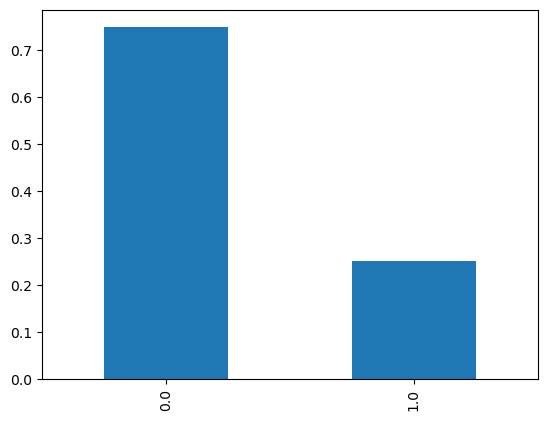

In [9]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [10]:
x = df.drop('mortality',axis=1)
x = x.fillna(x.mean(skipna=True)).values
x /= x.mean()
y = df.mortality.values

In [11]:
#def log_logistic_fn(x):
#    return np.log(1+np.exp(-x)) 


class logisticModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __logistic_loss(self,param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*logistic.logcdf(score, loc=0, scale=1) - (1-y)*logistic.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__logistic_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__logistic_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return logistic.cdf(score, loc=0, scale=1)


class probitModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __probit_loss(self, param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*norm.logcdf(score, loc=0, scale=1) - (1-y)*norm.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__probit_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__probit_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return norm.cdf(score, loc=0, scale=1)

In [12]:
probit = probitModel()
result, loss_values = probit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6927430849441866
Current loss: 0.6920101815652728
Current loss: 0.6858609348770089
Current loss: 0.6744141967870252
Current loss: 0.6555567707179731
Current loss: 0.6355197764115935
Current loss: 0.6263406618007572
Current loss: 0.6194067412236768
Current loss: 0.6142409119391503
Current loss: 0.6043416098727077
Current loss: 0.5866553050894638
Current loss: 0.5628596123189115
Current loss: 0.5593466476360627
Current loss: 0.5589331764599177
Current loss: 0.558149609395433
Current loss: 0.5520787712658511
Current loss: 0.5499190280811572
Current loss: 0.5472291394873768
Current loss: 0.5462303272748776
Current loss: 0.5460148721380461
Current loss: 0.5457152553922153
Current loss: 0.5452206916953394
Current loss: 0.5446470325895191
Current loss: 0.5445796916077016
Current loss: 0.5445501151396521
Current loss: 0.5444966644701206
Current loss: 0.5443993672863542
Current loss: 0.5442255730497073
Current loss: 0.5439320922507157
Current loss: 0.5435373394452324
Current los

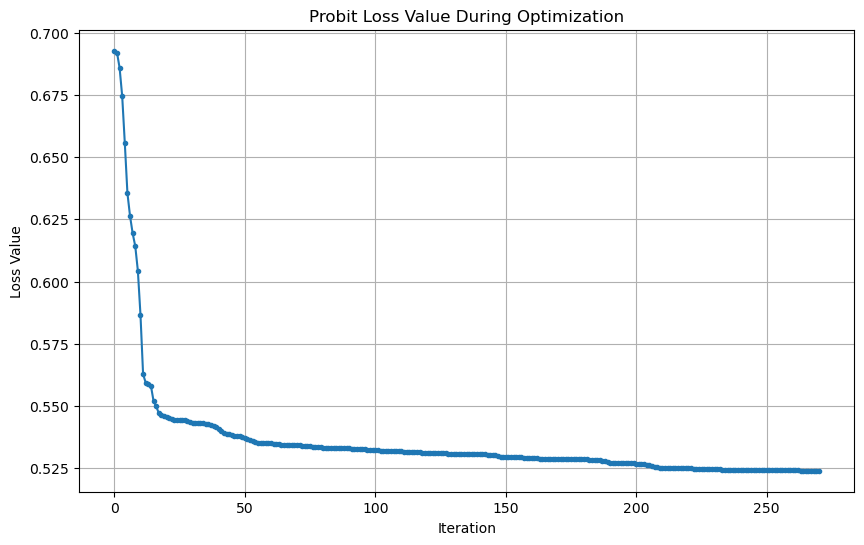

In [13]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

(array([ 288., 1908., 1885.,  914.,  411.,  165.,   51.,   20.,    2.,
           3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

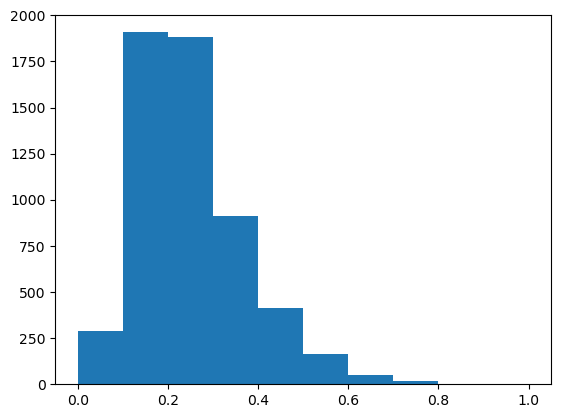

In [14]:
plt.hist(probit.predict(x))

In [15]:
logit = logisticModel()
result, loss_values = logit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6927794968116846
Current loss: 0.6897525861414787
Current loss: 0.6846150637626822
Current loss: 0.6412695824587831
Current loss: 0.6197338707226294
Current loss: 0.5879432453223778
Current loss: 0.574729964512975
Current loss: 0.5692223218443365
Current loss: 0.5666177767972942
Current loss: 0.5634632830119756
Current loss: 0.5628223887399778
Current loss: 0.5627430601129824
Current loss: 0.5620745556643931
Current loss: 0.5609932049378715
Current loss: 0.5605619563784202
Current loss: 0.5600023881467798
Current loss: 0.5592801783466482
Current loss: 0.5585743061158983
Current loss: 0.5575707100203654
Current loss: 0.5574920537823289
Current loss: 0.5567512012080884
Current loss: 0.5553803207206467
Current loss: 0.5544749509730909
Current loss: 0.552945590703307
Current loss: 0.5506006525461924
Current loss: 0.5500328984367066
Current loss: 0.5497342993133606
Current loss: 0.5492149734148691
Current loss: 0.5484722324807565
Current loss: 0.5481472510699225
Current loss

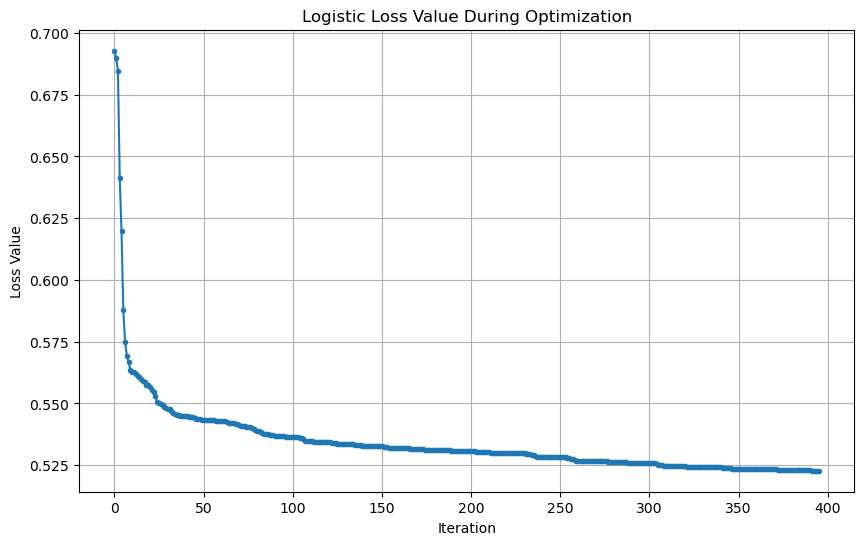

In [16]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

In [17]:
logit.predict(x)

array([0.22596826, 0.17623928, 0.19803212, ..., 0.20387007, 0.2234427 ,
       0.1713894 ])

(array([ 284., 2014., 1812.,  870.,  400.,  173.,   60.,   25.,    6.,
           3.]),
 array([8.14961089e-04, 1.00733465e-01, 2.00651969e-01, 3.00570473e-01,
        4.00488977e-01, 5.00407481e-01, 6.00325984e-01, 7.00244488e-01,
        8.00162992e-01, 9.00081496e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

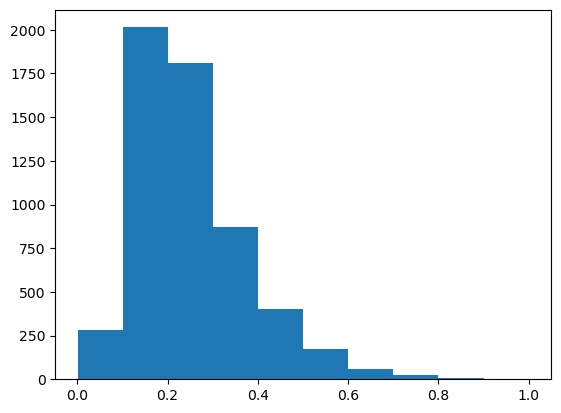

In [18]:
plt.hist(logit.predict(x))

In [19]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x, y)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [20]:
from sklearn.metrics import log_loss

log_loss(y, model.predict_proba(x), eps=1e-15)

/Users/gisellechan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


0.5363497736619606